# Frequency-switched Data Reduction

This notebook shows how to use `dysh` to calibrate a frequency switched observations. The idea is similar to an OnOff observation, except the telescope does not move to an Off in position on the sky, but moves its intermediate frequency in frequency space. Here we call the On and Off the Sig and Ref, but both will have the signal, just shifted in the band. Since the telescope is always tracking the target, combining the Sig and a shifted (folded) Ref, a $\sqrt{2}$ improvement in signal-to-noise can be achieved.

The retrieval and calibration of frequency-switched observations uses `GBTFITSLoad.getfs()`, which returns a `ScanBlock` object. 

## Dysh commands

The following dysh commands are introduced (leaving out all the function arguments):

      filename = dysh_data()
      sdf = GBTFITSLoad()
      sdf.select()
      sb = sdf.getfs()
      ta = sb.timeaverage()
      ta.baseline()
      ta.average()
      ta.plot()

## Loading Modules
We start by loading the modules we will use for this example. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for working with the data.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.log import init_logging

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

In [2]:
init_logging(2)

## Data Retrieval

Download the example SDFITS data, if necessary.

In [3]:
filename = dysh_data(example="getfs2")

10:54:57.119 I Resolving example=getfs2 -> frequencyswitch/data/TREG_050627/TREG_050627.raw.acs/


## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [4]:
sdfits = GBTFITSLoad(filename)
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
90,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.2283,18.1145
91,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.3521,18.2098
92,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.4739,18.3043
93,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.5953,18.3993
94,W3OH,0.0,Track,1,1.667359,1.667359,1,2,6,1,22.7163,18.4949


This data set contains 5 scans, 90 through 94. Each scan observed a single spectral window in two polarizations.

## Data Reduction

### Single Scan

The default is to fold the Sig and Ref to create the final spectrum.  Use `fold=False` to not fold them and `use_sig=False` to reverse the role of Sig and Ref. We will start calibrating `scan=90` (there are 5), `ifnum=0` (there is 1) and `plnum=1` (there are 2).

In [5]:
fs_scan_block = sdfits.getfs(scan=90, ifnum=0, plnum=1, fdnum=0)

The return of `sdfits.getfs` is a `ScanBlock` which contains a single `FSScan`. The `FSScan` contains the calibrated data for all of the integrations. Now we will time average the integrations.

#### Time Averaging
To time average the contents of a `ScanBlock` use its `timeaverage` method. Be aware that time averging will not check if the source is the same. 

By default time averaging uses the following weights: 
$$
\frac{T^{2}_{sys}}{\Delta\nu\Delta t}
$$
with $T_{sys}$ the system temperature, $\Delta\nu$ the channel width and $\Delta t$ the integration time. In `dysh` these are set using `weights='tsys'` (the default).

In [6]:
ta = fs_scan_block.timeaverage(weights='tsys')

#### Plotting
Plot the data and use different units for the spectral axis.

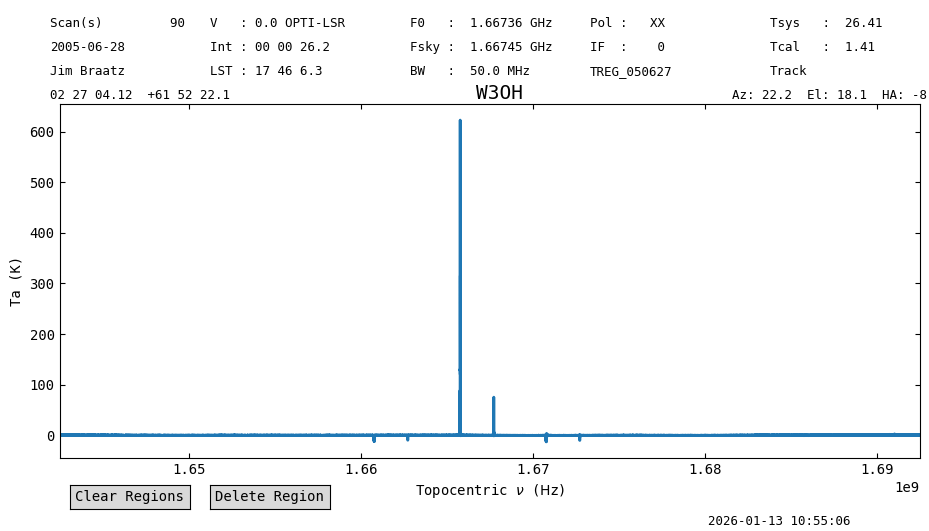

In [7]:
ta.plot()

Now change the x-axis units to km s$^{-1}$ and restrict the range being shown.

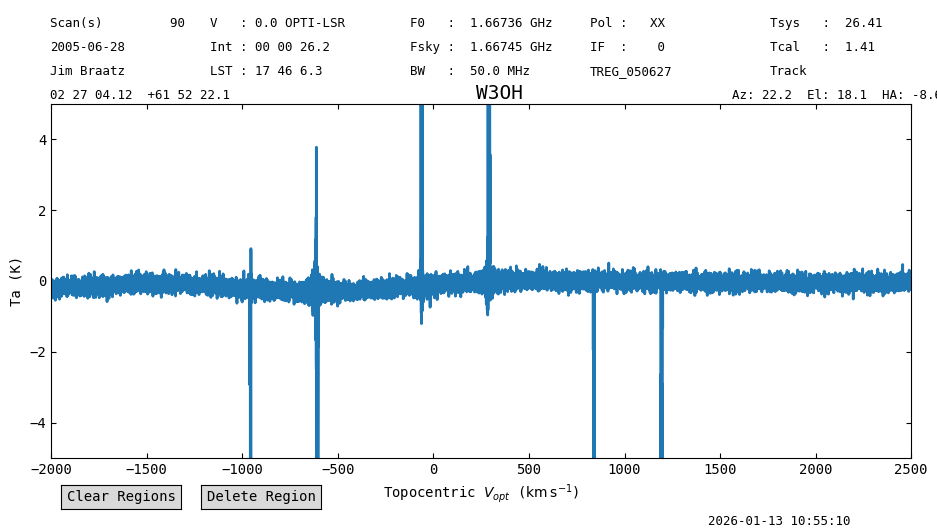

In [8]:
ta.plot(xaxis_unit="km/s", yaxis_unit="K", ymin=-5, ymax=5, xmin=-2000, xmax=2500)

#### Baseline Subtraction

Next we remove a baseline from the data.

We zoom in into the baseline to determine which model the use.

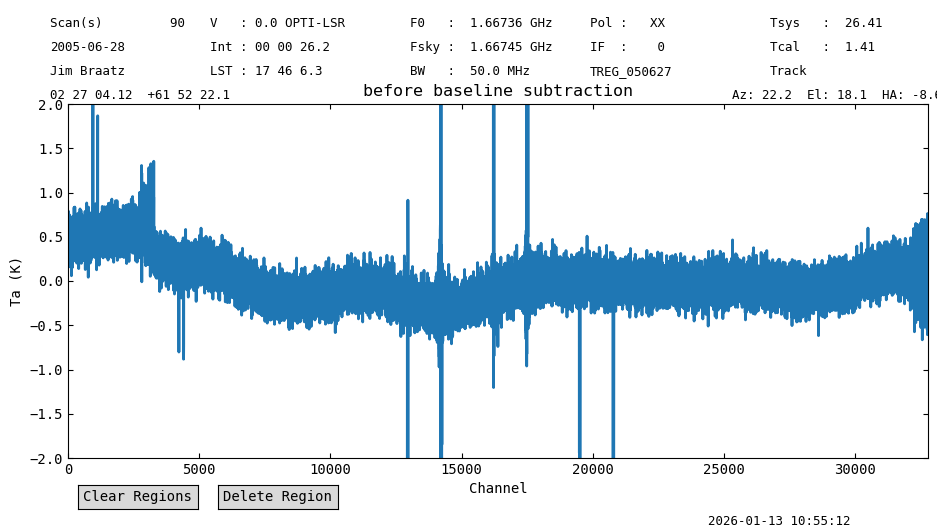

In [9]:
ta.plot(xaxis_unit="chan", yaxis_unit="K", ymin=-2, ymax=2, title="before baseline subtraction")

The baseline looks quasi-periodic, so a Chebyshev (`model='chebyshev'`) polynomial model may be a good model to use. Other available alternatives are: **hermite**, **legendre** and classic **polynomial**

For baseline subtraction it is possible to specify the range of channels to be included in the fit (using the `include` argument) or excluded (using the `exclude` argument). Only one channel selection can be used at a time.

We will also look at the mean, rms, min and max of the data before and after baseline subtraction.

10:55:12.830 I EXCLUDING [Spectral Region, 1 sub-regions:
  (1642454441.0 Hz, 1643624790.1210938 Hz) 
, Spectral Region, 1 sub-regions:
  (1658883579.1835938 Hz, 1677194126.0585938 Hz) 
, Spectral Region, 1 sub-regions:
  (1686044223.7148438 Hz, 1692452915.1210938 Hz) 
]


Before baseline subtraction -- mean: 0.1734 K median: 0.1736 K rms: 0.140 K min: -0.88 K max: 0.60 K
After baseline subtraction -- mean: -0.0089 K median: -0.0085 K rms: 0.145 K min: -1.10 K max: 0.45 K


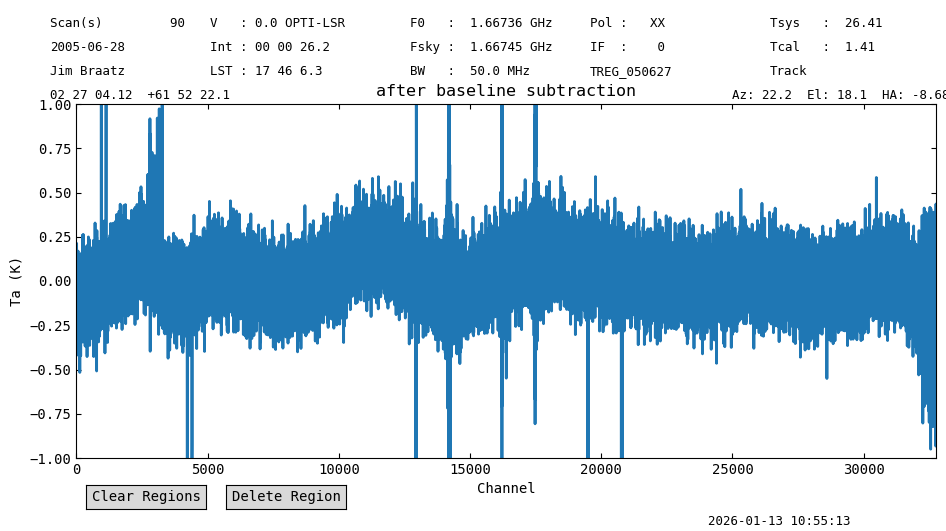

In [10]:
# Define a string.
fmt_str = "mean: {mean:.4f} median: {median:.4f} rms: {rms:.3f} min: {min:.2f} max: {max:.2f}"
# Print the statistics before baseline subtraction.
print(f"Before baseline subtraction -- {fmt_str}".format(**ta[4200:5300].stats()))

# Subtract the baseline.
ta.baseline(model="chebyshev", degree=5, include=[(4200,10000),(22000,32000)], remove=True)

# Print the statistics after baseline subtraction.
print(f"After baseline subtraction -- {fmt_str}".format(**ta[4200:5300].stats()))

# Now plot the baseline subtracted spectrum.
ta.plot(xaxis_unit="chan", yaxis_unit="K", ymin=-1, ymax=1, title="after baseline subtraction")

Now we will undo this baseline fit, and plot it again to see if we get the same spectrum back. Also adding the statistics on the first section of the baseline to confirm the statistics are all the same as before we started fitting.

After undoing the baseline subtraction -- mean: 0.1734 K median: 0.1736 K rms: 0.140 K min: -0.88 K max: 0.60 K


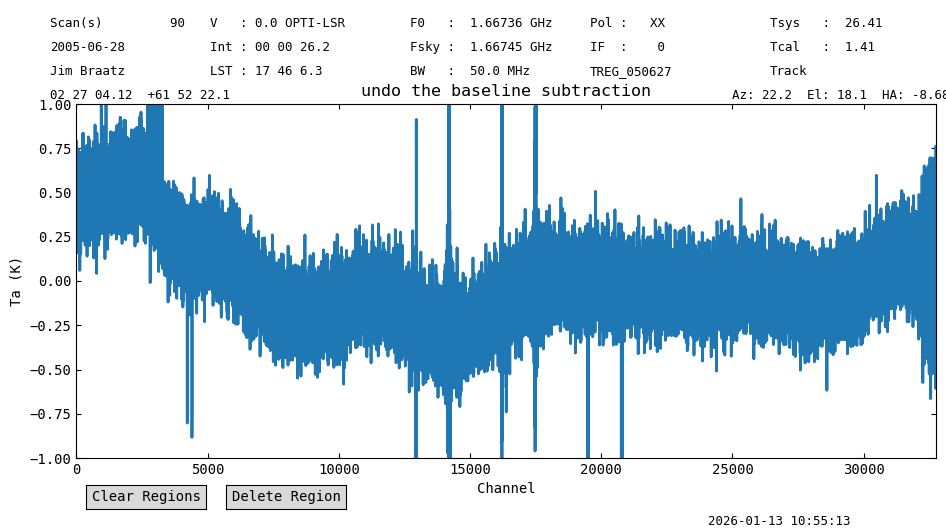

In [11]:
ta.undo_baseline()
ta_plt = ta.plot(xaxis_unit="chan", yaxis_unit="K", ymin=-1, ymax=1, title='undo the baseline subtraction')
print(f"After undoing the baseline subtraction -- {fmt_str}".format(**ta[4200:5300].stats()))

In [12]:
output_dir = Path.cwd() / "output"
ta_plt.savefig(output_dir / "baselined_removed.png")

#### Using Selection

We will repeat the calibration of `scan=90` using selection. To do this we pre-select the data using the `sdfits.select()` method.

In [13]:
sdfits.select(scan=90)

Using selection polarization 1 -- mean: 0.1734 K median: 0.1736 K rms: 0.140 K min: -0.88 K max: 0.60 K


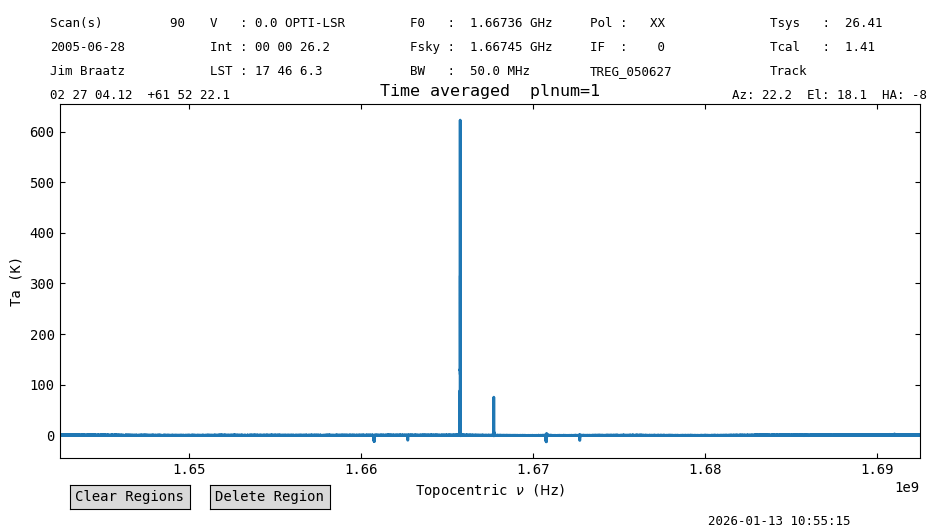

In [14]:
fs_scan_block2 = sdfits.getfs(plnum=1, ifnum=0, fdnum=0)
ta2 = fs_scan_block2.timeaverage()
ta2.plot(title='Time averaged  plnum=1')
print(f"Using selection polarization 1 -- {fmt_str}".format(**ta2[4200:5300].stats()))

#### Polarization Average

Now we will calibrate the other polarization and average the two polarizations together.

First we calibrate the second polarization, then time average it and inspect the time-averaged calibrated spectrum.

Using selection polarization 0 -- mean: 0.3231 K median: 0.3269 K rms: 0.135 K min: -0.42 K max: 0.81 K


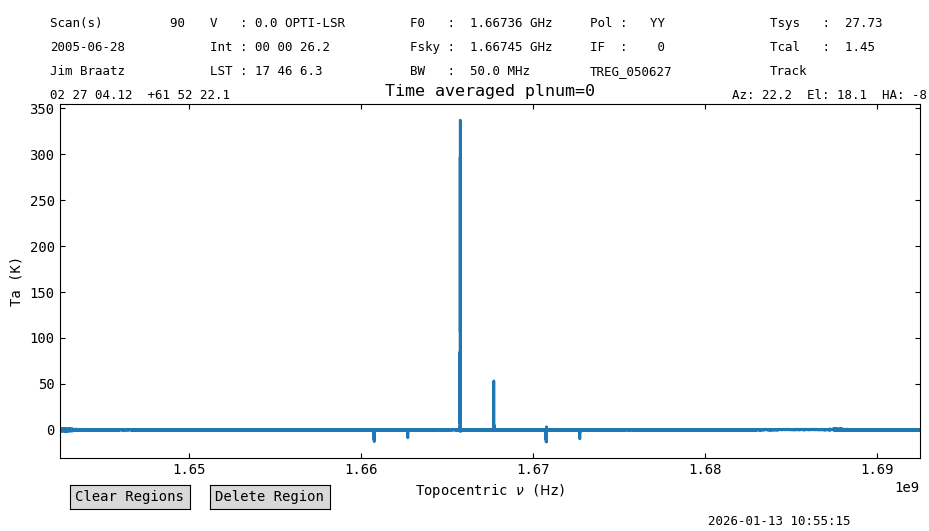

In [15]:
fs_scan_block3 = sdfits.getfs(plnum=0, ifnum=0,fdnum=0)
ta3 = fs_scan_block3.timeaverage()
ta3.plot(title='Time averaged plnum=0')
print(f"Using selection polarization 0 -- {fmt_str}".format(**ta3[4200:5300].stats()))

Now we average the polarizations.

Polarization average -- mean: 0.2446 K median: 0.2473 K rms: 0.105 K min: -0.66 K max: 0.55 K


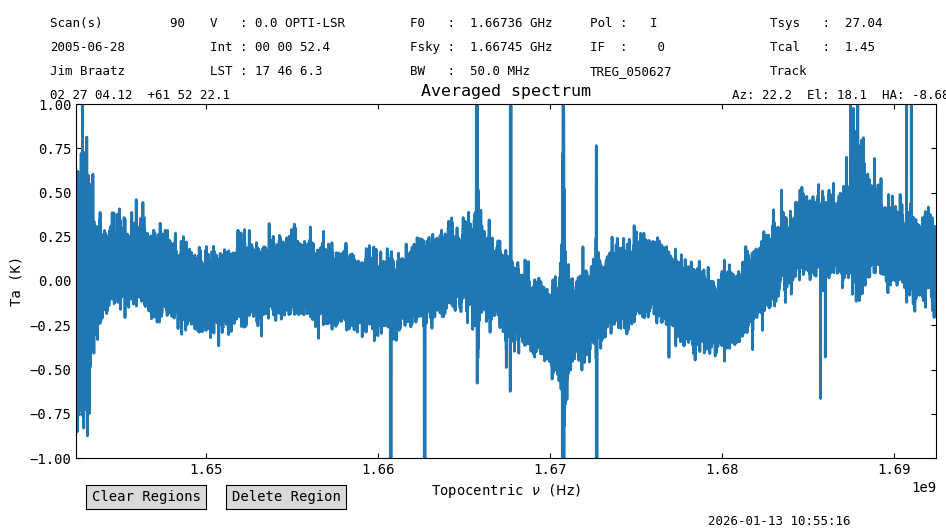

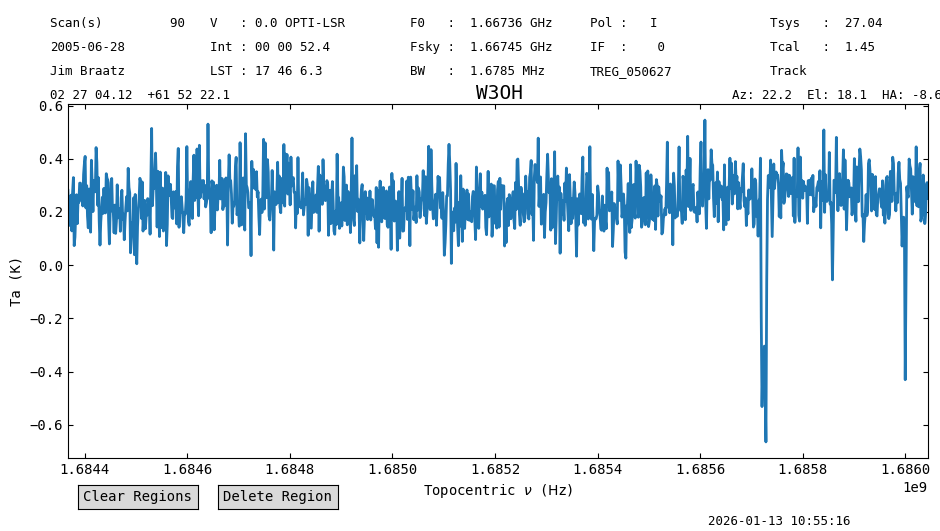

In [16]:
# avg = 0.5*(ta2 + ta3)
avg = ta2.average(ta3)
avg.plot(ymin=-1,ymax=1, title='Averaged spectrum')
avg[4200:5300].plot()
print(f"Polarization average -- {fmt_str}".format(**avg[4200:5300].stats()))

The noise is reduced by 1.34. Not exactly a factor of $\sqrt{2}$, likely because of the baseline.

## Final Stats

In [17]:
avg.stats()  # rms 4.72889473 K

{'mean': <Quantity 0.09261318 K>,
 'median': <Quantity -0.00125864 K>,
 'rms': <Quantity 4.72889473 K>,
 'min': <Quantity -13.13669757 K>,
 'max': <Quantity 467.87728953 K>,
 'npt': 32768,
 'nan': 0}

0.9542747726517753

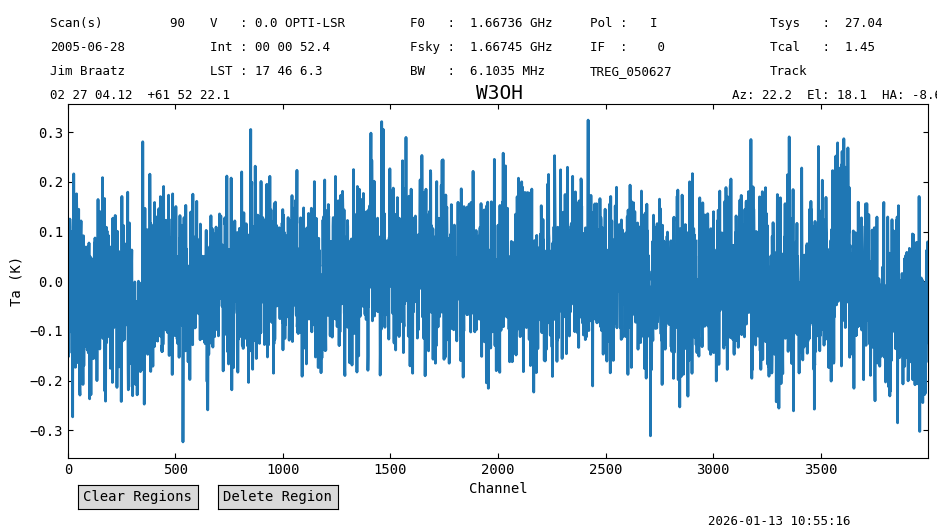

In [18]:
avg[23000:27000].plot(xaxis_unit="chan").spectrum.radiometer()  # 0.9542747726517753